# DATA 620 - Final Project

Jeremy OBrien, Mael Illien, Vanita Thompson

## Topic Networks

### Introduction

A powerful analytical application of NLP is topic modeling, which identifies the themes present in a corpus comprised of multiple documents based on the words in those documents. Because it can be used to uncover the thematic structure in documents, topic modeling has an array of applications in information retrieval and document mining.

Topics are 'probability distributions over a fixed vocabulary' 'An overview of topic modeling and its current applications in bioinformatics', and it's common to use probabilistic generative models derived from LDA (Latent Dirichlet Allocation) to model in an unsupervised fashion the latent semantic structure of documents. Topic models can be tuned and optimized in a variety of ways, including improving how topics are segregated from each other and calibrating for a useful number of topics.

### Research Question
We will combine techniques from topic modeling and network analysis to address this question.

Given a text corpus comprised of multiple documents, what are the topics of those documents and how are the documents thematically related to one another?

### Approach
- Leverage the Reuters news corpus of nearly 11,000 articles (labeled with at least one category each; unfortunately, authorship is not labeled)
- Using the NLTK, Spacy, and Gensim packages, implement and tune an unsupervised LDA-based topic model (i.e. without reference to the provided article topic labels)
- Analyze model perplexity and coherence, overall topic prevalence, and topic distribution across articles
- Generate a bipartite, weighted (likely on coherence) graph of articles and topics, and analyze its topology to identify relationships between topics

## Setup

In [25]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
from nltk.corpus import stopwords
from nltk.corpus import reuters

import spacy  # need to install

import gensim  # need to install
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

## Data Import & Processing

### Data import and preliminary EDA

In [2]:
# NLTK Reuters corpus test
from nltk.corpus import reuters
reuters.fileids()
reuters.words('test/14841')[-10:]

['the', 'shipment', 'was', 'for', 'April', '8', 'to', '20', 'delivery', '.']

In [3]:
reuters.categories()

['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc']

In [4]:
# Adjust to generate dataframe directly from nltk corpus
# https://stackoverflow.com/questions/46109166/converting-categorizedplaintextcorpusreader-into-dataframe
news = []
for fileid in reuters.fileids():
    tag, filename = fileid.split('/')
    news.append((filename, tag, reuters.raw(fileid)))

df = pd.DataFrame(news, columns=['filename', 'tag', 'text'])

In [5]:
df.head(n=5)

,filename,tag,text
0,14826,test,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...
1,14828,test,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...
2,14829,test,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...
3,14832,test,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n ...
4,14833,test,INDONESIA SEES CPO PRICE RISING SHARPLY\n Ind...


In [6]:
# Output with print

# 10,788 separate cases (news articles)
# df.shape
# len(df.filename.unique())

# Each case is tagged as either train or test
# df.tag.unique()

# There are 10,657 articles with distinct text body - so 131 duplicates
# len(df.text.unique())

# Check the text body of duplicates (except for first instance)
# print(df[df.text.duplicated('first')])

# JO: Evaluate cause and consider case for removal

### Data cleaning and deduplication

In [7]:
# Convert to list
data = df['text'].values.tolist()

# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]

pprint(data[0][:1000])

('ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT Mounting trade friction '
 'between the U.S. And Japan has raised fears among many of Asias exporting '
 'nations that the row could inflict far-reaching economic damage, businessmen '
 'and officials said. They told Reuter correspondents in Asian capitals a U.S. '
 'Move against Japan might boost protectionist sentiment in the U.S. And lead '
 'to curbs on American imports of their products. But some exporters said that '
 'while the conflict would hurt them in the long-run, in the short-term Tokyos '
 'loss might be their gain. The U.S. Has said it will impose 300 mln dlrs of '
 'tariffs on imports of Japanese electronics goods on April 17, in retaliation '
 'for Japans alleged failure to stick to a pact not to sell semiconductors on '
 'world markets at below cost. Unofficial Japanese estimates put the impact of '
 'the tariffs at 10 billion dlrs and spokesmen for major electronics firms '
 'said they would virtually halt exports of

### Text preparation and feature engineering

In [8]:
# Tokenize words and clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[0])

['asian', 'exporters', 'fear', 'damage', 'from', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asias', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter', 'correspondents', 'in', 'asian', 'capitals', 'move', 'against', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', 'run', 'in', 'the', 'short', 'term', 'tokyos', 'loss', 'might', 'be', 'their', 'gain', 'the', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', 'april', 'in', 'retaliation', 'for', 'japans', 'alleged', 'failur

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['asian', 'exporters', 'fear', 'damage', 'from', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asias', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter_correspondents', 'in', 'asian', 'capitals', 'move', 'against', 'japan', 'might', 'boost', 'protectionist_sentiment', 'in', 'the', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', 'run', 'in', 'the', 'short_term', 'tokyos', 'loss', 'might', 'be', 'their', 'gain', 'the', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', 'april', 'in', 'retaliation', 'for', 'japans', 'alleged_failure', 'to', 's

### Pre-processing

In [10]:
# Set up stopwords
stop_words = stopwords.words('english')

# JO: Confirm if these / other stopwords should be added
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [15]:
print(data_lemmatized[0])

['asian', 'exporter', 'fear', 'damage', 'mount', 'trade', 'friction', 'raise', 'fear', 'many', 'asia', 'export', 'nation', 'row', 'could', 'inflict', 'far', 'reach', 'economic', 'damage', 'businessman', 'official', 'say', 'tell', 'asian', 'capital', 'move', 'may', 'boost', 'protectionist_sentiment', 'lead', 'curb', 'american', 'import', 'product', 'exporter', 'say', 'conflict', 'would', 'hurt', 'long', 'run', 'tokyos', 'loss', 'may', 'gain', 'say', 'impose', 'dlrs', 'import', 'japanese', 'electronic', 'good', 'retaliation', 'stick', 'pact', 'sell', 'semiconductor', 'world', 'market', 'cost', 'unofficial', 'japanese', 'estimate', 'put', 'impact', 'tariff', 'dlrs', 'spokesman', 'major', 'electronic', 'firm', 'say', 'would', 'virtually', 'halt', 'export', 'product', 'hit', 'new', 'taxis', 'would', 'able', 'business', 'say', 'spokesman', 'lead', 'japanese', 'electronic', 'firm', 'tariff', 'remain', 'place', 'length', 'time', 'month', 'mean', 'complete', 'erosion', 'export', 'good', 'tariff

In [16]:
# Create dictionary and corpus for topic modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 4), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 2), (35, 1), (36, 3), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 4), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 4), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 8), (61, 2), (62, 1), (63, 1), (64, 2), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 6), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 5), (86, 1), (87, 2), (88, 4), (89, 3), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 1), (96, 1), (97, 3), (98, 1), (99, 4), (100, 1), (101, 1), (102, 3), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('accounting', 1),
  ('action', 1),
  ('advantage', 1),
  ('allege', 1),
  ('allow', 2),
  ('also', 4),
  ('american', 1),
  ('asia', 1),
  ('asian', 2),
  ('ask', 1),
  ('australia', 1),
  ('australian', 1),
  ('avow', 1),
  ('await', 1),
  ('aware', 1),
  ('barrier', 1),
  ('beef', 1),
  ('big', 1),
  ('block', 1),
  ('boost', 2),
  ('budget', 1),
  ('business', 1),
  ('businessman', 3),
  ('call', 1),
  ('capital', 1),
  ('centre', 1),
  ('chief', 1),
  ('coal', 1),
  ('commercial', 1),
  ('complete', 1),
  ('concern', 2),
  ('conflict', 1),
  ('continue', 1),
  ('cost', 2),
  ('could', 1),
  ('country', 3),
  ('curb', 1),
  ('cut', 1),
  ('damage', 2),
  ('day', 1),
  ('defuse', 1),
  ('deputy', 1),
  ('deterioration', 1),
  ('diplomatic', 1),
  ('disadvantage', 1),
  ('dispute', 2),
  ('dlrs', 4),
  ('domestically_produced', 1),
  ('due', 1),
  ('economic', 2),
  ('economy', 2),
  ('effort', 1),
  ('electronic', 4),
  ('emergency', 1),
  ('end', 1),
  ('erosion', 

## Topic Modeling & Distribution using Gensim

### Preliminary Topic Model

JO: May eliminate in favor of iterative approach to select optimal number of topics below.

In [18]:
# Build topic model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # TDF corpus
                                           id2word=id2word,  # dictionary
                                           num_topics=20,  # provisionally set to 20, to be optimized
                                           random_state=100,  # [CONFIRM]
                                           update_every=1,  # how often paramater should be updated
                                           chunksize=100,
                                           passes=10,  # total number of training passes
                                           alpha='auto',  # learn assymetric alpha from training data
                                           per_word_topics=True)

In [49]:
# View topics in LDA model
pprint(lda_model.print_topics())

[(0,
  '0.101*"year" + 0.073*"say" + 0.052*"rise" + 0.032*"expect" + 0.029*"end" + '
  '0.028*"dlrs" + 0.027*"report" + 0.027*"fall" + 0.025*"increase" + '
  '0.025*"first"'),
 (1,
  '0.387*"oil" + 0.073*"reserve" + 0.072*"crude" + 0.068*"barrel" + '
  '0.054*"revise" + 0.051*"morning" + 0.035*"day" + 0.021*"estimate" + '
  '0.018*"assistance" + 0.018*"today"'),
 (2,
  '0.287*"stock" + 0.178*"share" + 0.128*"common" + 0.081*"dividend" + '
  '0.020*"march" + 0.020*"grower" + 0.017*"corporate" + 0.015*"together" + '
  '0.015*"increase" + 0.014*"trust"'),
 (3,
  '0.133*"say" + 0.066*"company" + 0.048*"share" + 0.029*"offer" + 0.022*"buy" '
  '+ 0.022*"dlrs" + 0.019*"unit" + 0.016*"sell" + 0.015*"group" + '
  '0.014*"shareholder"'),
 (4,
  '0.150*"dollar" + 0.090*"currency" + 0.086*"exchange" + 0.086*"mark" + '
  '0.074*"dealer" + 0.074*"yen" + 0.054*"bank" + 0.030*"central" + '
  '0.021*"fall" + 0.021*"intervene"'),
 (5,
  '0.172*"price" + 0.038*"raise" + 0.024*"consumer" + 0.021*"stake" 

### Analyzing Perplexity and Coherence

Perplexity is measure of how well probability distribution / model predicts score
https://en.wikipedia.org/wiki/Perplexity

https://cfss.uchicago.edu/notes/topic-modeling/, provides examples on optimizing perplexity

Coherence is the degree of semantic similarity bnetween high scoring keywords in the topic
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

http://qpleple.com/topic-coherence-to-evaluate-topic-models/, provide intrinsic and extrinsic measures

In [35]:
# Compute model perplexity and coherence score

# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_lemmatized, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score', coherence_lda )


Perplexity:  -10.914410682837286

Coherence Score 0.4120619539894778


### Optimizing Number of Topics Parameter

In [ ]:
# Consider splitting the model function and the optimization

# Find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 # corpus=corpus, 
                                                 # num_topics=num_topics, 
                                                 # id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # TDF corpus
                                           id2word=id2word,  # dictionary
                                           num_topics=num_topics,  # to be optimized
                                           random_state=100,  # [CONFIRM]
                                           # update_every=1,  # how often paramater should be updated
                                           # chunksize=100,
                                           # passes=10,  # total number of training passes
                                           # alpha='auto',  # learn assymetric alpha from training data
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Iterate to find optimal model
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

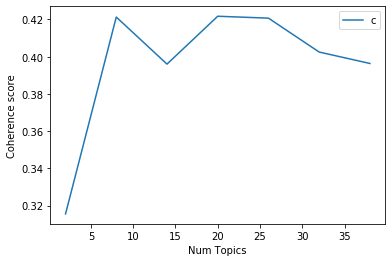

Num topics= 2  has coherence value of 0.3156
Num topics= 8  has coherence value of 0.4213
Num topics= 14  has coherence value of 0.396
Num topics= 20  has coherence value of 0.4217
Num topics= 26  has coherence value of 0.4207
Num topics= 32  has coherence value of 0.4025
Num topics= 38  has coherence value of 0.3964


In [34]:
# Graph iterations
limit=40; start=2; step=6
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print('Num topics=', m, ' has coherence value of', round(cv, 4))

In [32]:
# Set n to optimal model
n = 4
optimal_model= model_list[n]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(13,
  '0.057*"say" + 0.022*"offer" + 0.017*"licence" + 0.015*"bonus" + '
  '0.015*"wheat" + 0.012*"export" + 0.011*"tonne" + 0.011*"today" + '
  '0.011*"take" + 0.011*"market"'),
 (2,
  '0.039*"say" + 0.034*"soybean" + 0.031*"acre" + 0.027*"program" + '
  '0.017*"regular" + 0.017*"acreage" + 0.017*"set" + 0.014*"crop" + '
  '0.014*"initial" + 0.013*"aluminium"'),
 (12,
  '0.076*"franc" + 0.024*"french" + 0.022*"say" + 0.013*"cable" + '
  '0.013*"official" + 0.012*"new" + 0.011*"employer" + 0.010*"issue" + '
  '0.010*"redundancy" + 0.009*"sector"'),
 (1,
  '0.064*"oil" + 0.061*"price" + 0.048*"corn" + 0.046*"say" + 0.041*"raise" + '
  '0.028*"crude" + 0.017*"today" + 0.017*"qtly" + 0.015*"tender" + '
  '0.015*"barrel"'),
 (0,
  '0.059*"say" + 0.023*"rate" + 0.015*"growth" + 0.012*"economy" + '
  '0.011*"would" + 0.011*"economic" + 0.010*"dollar" + 0.010*"year" + '
  '0.009*"first" + 0.008*"exchange"'),
 (25,
  '0.060*"price" + 0.040*"say" + 0.029*"year" + 0.024*"production" + '
  '0.0

### Topic Prevalence

In [36]:
# JO: troubleshoot TypeError:  https://cs50.stackexchange.com/questions/30671/typeerror-not-supported-between-instances-of-int-and-tuple

# Find dominant topic by sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: '<' not supported between instances of 'int' and 'tuple'

### Topic Distribution

In [ ]:
# Depends on preceding code which needs troubleshooting
# Will need to be adjusted for Gensim rather than MALLET

# Find most representative document by topic
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

In [37]:
# Depends on preceding code which needs troubleshooting
# Will need to be adjusted for Gensim rather than MALLET

# Evaluate topic distribution across documents

# Number of documents by topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of documents by topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic number and keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate columns
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Set column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

df_dominant_topics

NameError: name 'df_topic_sents_keywords' is not defined

## Topic modeling using MALLET

Perplexity is measure of how well probability distribution / model predicts score
https://en.wikipedia.org/wiki/Perplexity

https://cfss.uchicago.edu/notes/topic-modeling/, provides examples on optimizing perplexity

Coherence is the degree of semantic similarity bnetween high scoring keywords in the topic
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

http://qpleple.com/topic-coherence-to-evaluate-topic-models/, provide intrinsic and extrinsic measures

In [ ]:
# Build LDA Mallet model
# Tutorial on setup: https://www.thinkinfi.com/2019/08/LDA-Gensim-Python.html
mallet_path = './mallet-2.0.8/bin/mallet'  # erroring
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=20,
                                            id2word=id2word)

# Show topics
pprint(ldamallet.show_topics(formatted=False))

# Compute coherence score
cpoherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                            texts=data_lemmatized,
                                            dictionary=id2word, 
                                            coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\
nCoherence score: ', coherence_ldamallet)

## Network Analysis

## Conclusion

## YouTube